In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
from keras import optimizers
import tensorflow as tf 
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import joblib
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd "/content/drive/MyDrive/"

/content/drive/MyDrive


In [5]:
df= pd.read_csv('data_05_shaft_bearing.csv')

In [6]:
df= df.dropna()
df=df[df['power']>100]
df= df[df['outdoor_temp']>0]
df= df[df['nacelle']>0]
df= df[df['generator_speed']>0]
df= df[df['gearbox_bearing']>0]
df.drop(columns=["Unnamed: 0"],inplace=True)
print(df)

features = ['generator_speed', 'nacelle']
target = ['gearbox_bearing']
X = df[features]
y = df[target]

PredictorScaler=StandardScaler()
TargetVarScaler=StandardScaler()
PredictorScalerFit=PredictorScaler.fit(X)
TargetVarScalerFit=TargetVarScaler.fit(y)
X=PredictorScalerFit.transform(X)
y=TargetVarScalerFit.transform(y)

                      sample_time      power  outdoor_temp  generator_speed  \
0       2018-01-01 00:00:00+00:00  668.28204     32.369460        973.59010   
1       2018-01-01 00:10:00+00:00  396.09955     32.322247        851.24150   
2       2018-01-01 00:20:00+00:00  337.86740     32.230736        835.06190   
3       2018-01-01 00:30:00+00:00  326.90180     32.051624        830.00200   
4       2018-01-01 00:40:00+00:00  400.90637     31.891493        843.18300   
...                           ...        ...           ...              ...   
157809  2020-12-31 21:30:00+00:00  463.78204     30.680513        886.92694   
157810  2020-12-31 21:40:00+00:00  472.37115     30.551275        884.98804   
157811  2020-12-31 21:50:00+00:00  579.70490     30.431310        939.09460   
157812  2020-12-31 22:00:00+00:00  554.78850     30.328987        927.96220   
157813  2020-12-31 22:10:00+00:00  194.68222     30.234390        352.50555   

          nacelle  gearbox_bearing  
0       39.058

In [7]:
X_train= X[0:100000]
y_train= y[0:100000]
X_validation = X[10000:105120]
y_validation = y[10000:105120]
X_test= X[105120:]
y_test= y[105120:]

In [8]:
  model = Sequential()
  model.add(LSTM(100,activation='selu', input_shape = (X.shape[1],1),return_sequences=True))
  model.add(LSTM(200,activation='selu', return_sequences=False))
  model.add(Dense(1, activation='selu'))
  model.compile(optimizer='adam', loss="mse", metrics=['mae'])

In [9]:
# Fitting the ANN to the Training set
history= model.fit(X_train, y_train ,batch_size = 60, epochs = 10, validation_data=(X_validation, y_validation))

Epoch 1/10
1667/1667 [==============================] - 26s 15ms/step - loss: 0.3413 - mae: 0.4674 - val_loss: 0.3240 - val_mae: 0.4527
Epoch 2/10
1667/1667 [==============================] - 22s 13ms/step - loss: 0.3317 - mae: 0.4614 - val_loss: 0.3254 - val_mae: 0.4600
Epoch 3/10
1667/1667 [==============================] - 19s 11ms/step - loss: 0.3304 - mae: 0.4608 - val_loss: 0.3216 - val_mae: 0.4594
Epoch 4/10
1667/1667 [==============================] - 19s 11ms/step - loss: 0.3295 - mae: 0.4602 - val_loss: 0.3197 - val_mae: 0.4548
Epoch 5/10
1667/1667 [==============================] - 21s 12ms/step - loss: 0.3293 - mae: 0.4599 - val_loss: 0.3223 - val_mae: 0.4599
Epoch 6/10
1667/1667 [==============================] - 19s 11ms/step - loss: 0.3290 - mae: 0.4599 - val_loss: 0.3190 - val_mae: 0.4524
Epoch 7/10
1667/1667 [==============================] - 18s 11ms/step - loss: 0.3287 - mae: 0.4597 - val_loss: 0.3188 - val_mae: 0.4523
Epoch 8/10
1667/1667 [==========================

In [10]:
Predictions=model.predict(X_test)
Predictions=TargetVarScalerFit.inverse_transform(Predictions)
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)
Test_Data=PredictorScalerFit.inverse_transform(X_test)

In [11]:
df_teste=pd.DataFrame(data=Test_Data, columns=features)
df_teste['original']=y_test_orig
df_teste['predicted']=Predictions
df_teste.head()

,generator_speed,nacelle,original,predicted
0,1242.5048,29.280334,62.573334,64.651459
1,1440.3514,31.264334,65.407670,65.616020
2,1336.6907,29.424667,66.546330,64.943214
3,1430.4870,28.319500,63.864666,64.859718
4,1452.3634,28.371166,63.637500,64.890320


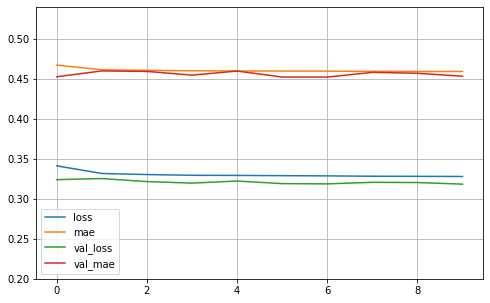

In [12]:
%matplotlib inline

import pandas as pd

import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.2, 0.54) # set the vertical range to [0-1]
plt.show()

In [13]:
# Computing the absolute percent error
APE=100*(abs(df_teste['original']-df_teste['predicted'])/df_teste['original'])
df_teste['APE']=APE
 
print('The Accuracy of ANN model is:', 100-np.mean(APE))
df_teste.head()

The Accuracy of ANN model is: 97.89136907607235


,generator_speed,nacelle,original,predicted,APE
0,1242.5048,29.280334,62.573334,64.651459,3.321103
1,1440.3514,31.264334,65.407670,65.616020,0.318541
2,1336.6907,29.424667,66.546330,64.943214,2.409022
3,1430.4870,28.319500,63.864666,64.859718,1.558064
4,1452.3634,28.371166,63.637500,64.890320,1.968682


In [14]:
df_new= df.merge(df_teste, how='left',on=['generator_speed','nacelle'])
df_new= df_new.dropna()
df_new

,sample_time,power,outdoor_temp,generator_speed,nacelle,gearbox_bearing,original,predicted,APE
105120,2020-06-13 12:20:00+00:00,1471.88950,21.637331,1242.50480,29.280334,62.573334,62.573334,64.651459,3.321103
105121,2020-06-13 12:30:00+00:00,2269.15700,21.958326,1440.35140,31.264334,65.407670,65.407670,65.616020,0.318541
105122,2020-06-13 12:40:00+00:00,1848.58220,22.357782,1336.69070,29.424667,66.546330,66.546330,64.943214,2.409022
105123,2020-06-13 12:50:00+00:00,2222.08180,22.545212,1430.48700,28.319500,63.864666,63.864666,64.859718,1.558064
105124,2020-06-13 13:00:00+00:00,2330.56880,22.536217,1452.36340,28.371166,63.637500,63.637500,64.890320,1.968682
...,...,...,...,...,...,...,...,...,...
129808,2020-12-31 21:20:00+00:00,547.44770,30.756876,922.46820,39.576168,66.319000,66.319000,64.001740,3.494113
129809,2020-12-31 21:30:00+00:00,463.78204,30.680513,886.92694,39.403336,65.438670,65.438670,63.126251,3.533719
129810,2020-12-31 21:40:00+00:00,472.37115,30.551275,884.98804,39.182835,64.908165,64.908165,63.035061,2.885776
129811,2020-12-31 21:50:00+00:00,579.70490,30.431310,939.09460,39.011333,64.766170,64.766170,64.180611,0.904113


In [15]:
df_teste['error']=df_teste['predicted'] - df_teste['original']
print(df_teste)

       generator_speed    nacelle   original  predicted       APE     error
0           1242.50480  29.280334  62.573334  64.651459  3.321103  2.078125
1           1440.35140  31.264334  65.407670  65.616020  0.318541  0.208350
2           1336.69070  29.424667  66.546330  64.943214  2.409022 -1.603116
3           1430.48700  28.319500  63.864666  64.859718  1.558064  0.995052
4           1452.36340  28.371166  63.637500  64.890320  1.968682  1.252820
...                ...        ...        ...        ...       ...       ...
24689        886.92694  39.403336  65.438670  63.126251  3.533719 -2.312419
24690        884.98804  39.182835  64.908165  63.035061  2.885776 -1.873104
24691        939.09460  39.011333  64.766170  64.180611  0.904113 -0.585559
24692        927.96220  38.867000  64.691170  63.974014  1.108584 -0.717156
24693        352.50555  40.111168  63.903500  59.203701  7.354525 -4.699799

[24694 rows x 6 columns]


Mean Error: 0.1773795273204176
MAE: 1.3558903109532552
RMSE: 1.770560889531374


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


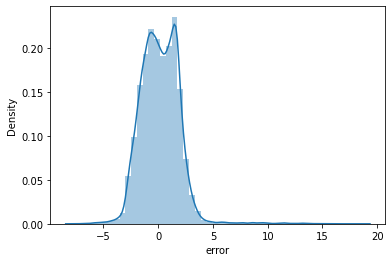

In [ ]:
%matplotlib inline
import seaborn as sns
print('Mean Error:', np.mean(df_teste['error']))
print('MAE:', np.mean(np.abs(df_teste['error'])))
print('RMSE:', np.sqrt(np.mean(df_teste['error']**2)))

sns.distplot(df_teste['error'])

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score

print(mean_absolute_error(df_teste['original'], df_teste['predicted']))
print(mean_squared_error(df_teste['original'], df_teste['predicted']))
print(r2_score(df_teste['original'], df_teste['predicted']))


1.336921322402347
3.07310723732997
0.45475447717728723


In [17]:
import scipy.stats as stats
df_teste['error']= -df_teste['predicted'] + df_teste['original'] 
#df_teste['error']=np.sqrt(df_teste['error'])
mean, dev = stats.norm.fit(df_teste['error'])


df_teste['error_gaussiano']=stats.norm.pdf(df_teste['error'], mean, dev)

In [18]:
mean, dev = stats.norm.fit(df_teste['error_gaussiano'])
epsilon=stats.norm.ppf(0.95, loc=mean, scale=dev)
print(epsilon)

0.2595436452928721


In [21]:
upper = mean - epsilon*dev/np.sqrt(df_teste.shape[0])
print(upper)
error3= df_teste[df_teste['error']>=upper]
error3

0.16837212716553426


,generator_speed,nacelle,original,predicted,APE,error,error_gaussiano
2,1336.69070,29.424667,66.546330,64.943214,2.409022,1.603116,0.131296
8,1427.85520,31.774834,67.612170,65.728867,2.785450,1.883303,0.109282
9,1453.60440,29.796167,66.161500,65.216164,1.428832,0.945336,0.182383
13,1398.18270,31.552168,66.933500,65.592949,2.002810,1.340551,0.152297
21,1429.23880,34.596170,67.008835,66.362579,0.964434,0.646256,0.201973
...,...,...,...,...,...,...,...
24689,886.92694,39.403336,65.438670,63.126251,3.533719,2.312419,0.078448
24690,884.98804,39.182835,64.908165,63.035061,2.885776,1.873104,0.110065
24691,939.09460,39.011333,64.766170,64.180611,0.904113,0.585559,0.205454
24692,927.96220,38.867000,64.691170,63.974014,1.108584,0.717156,0.197675


In [22]:
lower = mean + epsilon*dev/np.sqrt(df_teste.shape[0])
print(lower)

error2= df_teste[df_teste['error']<=lower]
error2

0.168555038549864


,generator_speed,nacelle,original,predicted,APE,error,error_gaussiano
0,1242.50480,29.280334,62.573334,64.651459,3.321103,-2.078125,0.130717
1,1440.35140,31.264334,65.407670,65.616020,0.318541,-0.208350,0.229601
3,1430.48700,28.319500,63.864666,64.859718,1.558064,-0.995052,0.208612
4,1452.36340,28.371166,63.637500,64.890320,1.968682,-1.252820,0.193343
5,1430.18080,28.596834,63.338170,64.911476,2.483978,-1.573306,0.170590
...,...,...,...,...,...,...,...
24679,1316.40360,36.734833,63.416668,66.466583,4.809327,-3.049915,0.061734
24680,1301.28480,36.620167,63.193000,66.386276,5.053212,-3.193276,0.053822
24681,920.30520,41.825170,57.664670,64.203690,11.339733,-6.539020,0.000317
24682,1006.97064,41.378500,62.231667,65.271027,4.883944,-3.039360,0.062344


In [24]:
error3= error3.reset_index(drop=True)
error2 = error2.reset_index(drop=True)
df_error= pd.concat([error3, error2], ignore_index=True)
df_error

,generator_speed,nacelle,original,predicted,APE,error,error_gaussiano
0,1336.69070,29.424667,66.546330,64.943214,2.409022,1.603116,0.131296
1,1427.85520,31.774834,67.612170,65.728867,2.785450,1.883303,0.109282
2,1453.60440,29.796167,66.161500,65.216164,1.428832,0.945336,0.182383
3,1398.18270,31.552168,66.933500,65.592949,2.002810,1.340551,0.152297
4,1429.23880,34.596170,67.008835,66.362579,0.964434,0.646256,0.201973
...,...,...,...,...,...,...,...
24690,1316.40360,36.734833,63.416668,66.466583,4.809327,-3.049915,0.061734
24691,1301.28480,36.620167,63.193000,66.386276,5.053212,-3.193276,0.053822
24692,920.30520,41.825170,57.664670,64.203690,11.339733,-6.539020,0.000317
24693,1006.97064,41.378500,62.231667,65.271027,4.883944,-3.039360,0.062344


In [35]:
df_new= df_error.merge(df, how='left',on=['generator_speed', 'nacelle'])
df_new= df_new.dropna()
df_new


,generator_speed,nacelle,original,predicted,APE,error,error_gaussiano,sample_time,power,outdoor_temp,gearbox_bearing
0,1336.69070,29.424667,66.546330,64.943214,2.409022,1.603116,0.131296,2020-06-13 12:40:00+00:00,1848.5822,22.357782,66.546330
1,1427.85520,31.774834,67.612170,65.728867,2.785450,1.883303,0.109282,2020-06-13 13:40:00+00:00,2192.5635,23.955042,67.612170
2,1453.60440,29.796167,66.161500,65.216164,1.428832,0.945336,0.182383,2020-06-13 13:50:00+00:00,2329.8643,23.995396,66.161500
3,1398.18270,31.552168,66.933500,65.592949,2.002810,1.340551,0.152297,2020-06-13 14:30:00+00:00,2092.5186,24.981665,66.933500
4,1429.23880,34.596170,67.008835,66.362579,0.964434,0.646256,0.201973,2020-06-13 15:50:00+00:00,2182.0388,26.337427,67.008835
...,...,...,...,...,...,...,...,...,...,...,...
24690,1316.40360,36.734833,63.416668,66.466583,4.809327,-3.049915,0.061734,2020-12-31 18:50:00+00:00,1120.6458,31.489042,63.416668
24691,1301.28480,36.620167,63.193000,66.386276,5.053212,-3.193276,0.053822,2020-12-31 19:00:00+00:00,1080.0697,31.216616,63.193000
24692,920.30520,41.825170,57.664670,64.203690,11.339733,-6.539020,0.000317,2020-12-31 20:10:00+00:00,586.4313,32.376850,57.664670
24693,1006.97064,41.378500,62.231667,65.271027,4.883944,-3.039360,0.062344,2020-12-31 20:20:00+00:00,724.7056,32.093470,62.231667
